In [8]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.layers import (
  Dense,
  Conv2D,
  GlobalMaxPooling2D,
  GlobalAveragePooling2D,
  MaxPooling2D,
  BatchNormalization,
  Dropout,
  Flatten,
)
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

print('Dependencies succesfully imported!')

"""Checking gpu device"""
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


Dependencies succesfully imported!
1 Physical GPUs, 1 Logical GPUs


In [2]:
# getting filepath for each split
train_path = r"dataset/train"
val_path = r"dataset/val"
test_path = r"dataset/test"

seed = 42
shuffle = True

# create image generator to augment images
datagen_train = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    rotation_range = 0.5,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    channel_shift_range = 1.0,
    horizontal_flip = True,
    vertical_flip = False,
    rescale = 1/255.,
    validation_split = 0.2
)

datagen_test = ImageDataGenerator(
    rescale = 1/255.,
)

def augment_data_train(path, subset, augmenter, target_size = (150,150), class_mode = 'categorical'):
    return augmenter.flow_from_directory(
        directory = path,
        batch_size = 16,
        target_size = target_size,
        class_mode = class_mode,
        seed = seed,
        shuffle = shuffle,
        subset = subset
    )

def augment_data_test(path, augmenter, target_size = (150,150), class_mode = 'categorical'):
    return augmenter.flow_from_directory(
        directory = path,
        batch_size = 8,
        target_size = target_size,
        class_mode = class_mode,
        seed = seed,
        shuffle = shuffle,
    )

# import files using image_dataset_from_directory
train = augment_data_train(train_path, 'training', augmenter = datagen_train)
val = augment_data_train(train_path, 'validation', augmenter = datagen_train)
test = augment_data_test(test_path, datagen_test)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
train.image_shape

(150, 150, 3)

In [3]:
# """Creating CNNBlock"""
# class CNNBlock(layers.Layer):
#     def __init__(self, out_channels, kernel_size):
#         super(CNNBlock, self).__init__()
#         self.conv = layers.Conv2D(out_channels, kernel_size, padding = 'same', input_shape = (None, None, None, None))
#         self.batch_norm = layers.BatchNormalization()

#     """Create function to run forward pass"""
#     """CNN -> BatchNormalization -> ReLu"""
#     def call(self, input, training = False):
#         x = self.conv(input)
#         print(x.shape)
#         x = self.batch_norm(x, training = training)
#         x = tf.nn.relu(x)
#         return x

In [5]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='swish', padding='same', input_shape=train.image_shape))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-3))
model.add(Conv2D(64, (3,3), activation='swish', padding='same'))
# model.add(GlobalMaxPooling2D())
model.add(MaxPooling2D(padding='same'))

model.add(Conv2D(128, (3,3), activation='swish', padding='same', input_shape=train.image_shape))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-3))
model.add(Conv2D(128, (3,3), activation='swish', padding='same'))
# model.add(GlobalMaxPooling2D())
model.add(MaxPooling2D(padding='same'))

model.add(Conv2D(256, (3,3), activation='swish', padding='same', input_shape=train.image_shape))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-3))
model.add(Conv2D(256, (3,3), activation='swish', padding='same'))
# model.add(GlobalMaxPooling2D())
model.add(MaxPooling2D(padding='same'))

model.add(Conv2D(512, (3,3), activation='swish', padding='same', input_shape=train.image_shape))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-3))
model.add(Conv2D(512, (3,3), activation='swish', padding='same'))
# model.add(GlobalMaxPooling2D())
model.add(MaxPooling2D(padding='same'))

model.add(Conv2D(512, (3,3), activation='swish', padding='same', input_shape=train.image_shape))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-3))
model.add(Conv2D(512, (3,3), activation='swish', padding='same'))
# model.add(GlobalMaxPooling2D())
model.add(MaxPooling2D(padding='same'))
model.add(Flatten())

model.add(Dense(4096, activation='swish'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='swish'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 128)      5

In [6]:
from keras.optimizers import SGD

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 1e-3),
    # optimizer = SGD(),
    # loss = keras.losses.CategoricalCrossentropy(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [7]:
history = model.fit(
    train,
    # batch_size = 32,
    # steps_per_epoch = 100,
    # validation_steps = 10,
    epochs = 20,
    validation_data = val
)

Epoch 1/20
261/261 [==============================] - 181s 652ms/step - loss: 3.2798 - accuracy: 0.7829 - val_loss: 0.3794 - val_accuracy: 0.8495
Epoch 2/20
261/261 [==============================] - 128s 488ms/step - loss: 0.4943 - accuracy: 0.8613 - val_loss: 0.3389 - val_accuracy: 0.8533
Epoch 3/20
261/261 [==============================] - 127s 486ms/step - loss: 0.3334 - accuracy: 0.8924 - val_loss: 0.2433 - val_accuracy: 0.9032
Epoch 4/20
261/261 [==============================] - 129s 493ms/step - loss: 0.3321 - accuracy: 0.8917 - val_loss: 0.3934 - val_accuracy: 0.8591
Epoch 5/20
261/261 [==============================] - 132s 507ms/step - loss: 0.2341 - accuracy: 0.9166 - val_loss: 0.4900 - val_accuracy: 0.7488
Epoch 6/20
261/261 [==============================] - 131s 500ms/step - loss: 0.2645 - accuracy: 0.9092 - val_loss: 0.1828 - val_accuracy: 0.9156
Epoch 7/20
261/261 [==============================] - 131s 500ms/step - loss: 4.4027 - accuracy: 0.8296 - val_loss: 0.6748 -

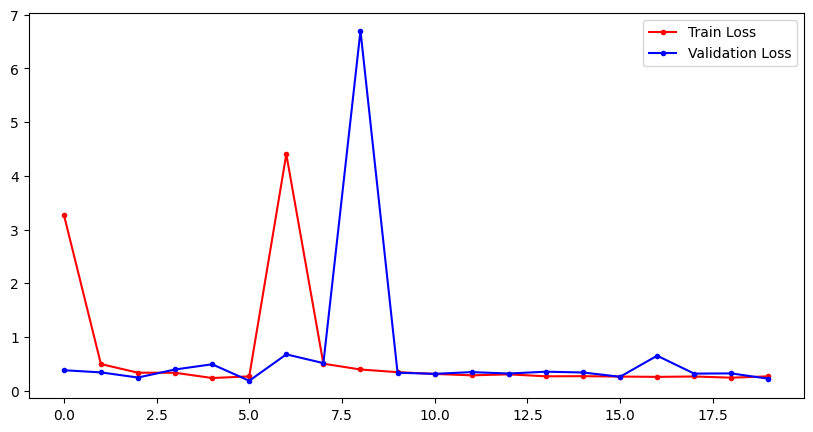

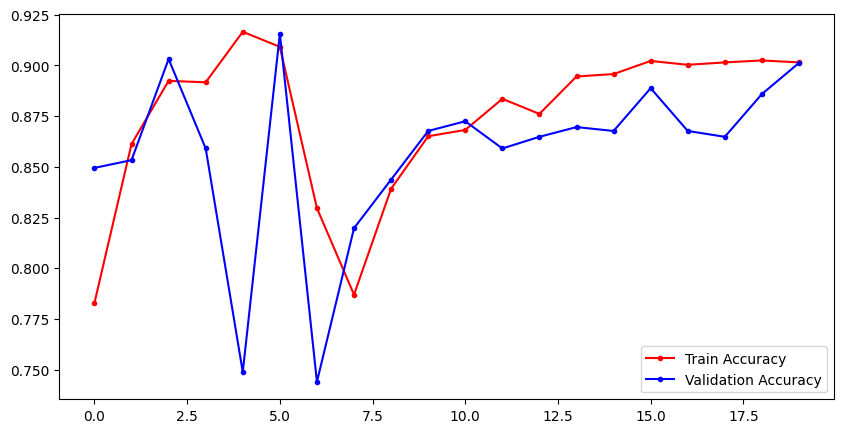

In [9]:
# plotting training history
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(history.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(history.history["val_loss"],'b', marker='.', label = "Validation Loss")
ax.legend()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(history.history["accuracy"],'r', marker='.', label="Train Accuracy")
ax.plot(history.history["val_accuracy"],'b', marker='.', label = "Validation Accuracy")
ax.legend()

In [12]:
test_loss, test_score = model.evaluate(test)
train_loss, train_score = model.evaluate(train)
val_loss, val_score = model.evaluate(val)

66/66 [==============================] - 29s 439ms/step - loss: 0.2553 - accuracy: 0.9022


In [18]:
print(f'='*35)

print(f'train loss: {train_loss}\ntrain score: {train_score}')
print(f'-'*35)
print(f'val loss: {val_loss}\nval score: {val_score}')
print(f'-'*35)
print(f'test loss: {test_loss}\ntest score: {test_score}')
print(f'='*35)

train loss: 0.18723173439502716
train score: 0.9237958192825317
-----------------------------------
val loss: 0.2552691698074341
val score: 0.9022051692008972
-----------------------------------
test loss: 0.626550018787384
test score: 0.7564102411270142


In [29]:
print(tf.debugging.set_log_device_placement(True))

None


In [30]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1418410185658158891
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2909221684
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9710639438715200636
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [31]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [32]:
tf.test.gpu_device_name()

'/device:GPU:0'